In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.optimize import curve_fit
from scipy.stats.distributions import t
from scipy.optimize import minimize
from scipy import stats
import scipy.optimize as optimize
from scipy.optimize import fsolve

**Non-linear Regression Analysis to Determine the Model Parameters k, Kb , and Kt**

You can download Fogler's book from here: https://doku.pub/download/h-scott-fogler-essentials-of-chemical-reaction-engineering-z0x2ze484wqn

In [4]:
# observed experimental reaction rates for the reaction C6H5CH3 + H2 → C6H6 + CH4 or t + h → b + m
data = pd.DataFrame({"r":[71,71.3,41.6,19.7,42.0,17.1,71.8, 
142.0,284.0,47.0,71.3,117.0,127.0,131.0,133.0,41.8], 
"t":[1,1,1,1,1,1,1,1,1,0.5,1,5,10,15,20,1], "h":[1,1,1,1,1,1,1,2,4,1,1,1,1,1,1,1],
"m":[1,4,0,0,1,0,0,0,0,0,0,0,0,0,0,1], "b":[0,0,1,4,1,5,0,0,0,0,0,0,0,0,0,1]
})

# multiple independent variables - partial pressures of components
x_data = df.iloc[:, 1:].T.values

# dependent variable - rate of reaction
y_observed = data["r"]

df = data

array([[ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0.5,  1. ,
         5. , 10. , 15. , 20. ,  1. ],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  2. ,  4. ,  1. ,  1. ,
         1. ,  1. ,  1. ,  1. ,  1. ],
       [ 1. ,  4. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  0. ,  1. ,  4. ,  1. ,  5. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  1. ]])

In [5]:
# calculate y
def calc_y(x, k, Kb, Kt):
    
    num = k*x[0]*x[1]
    denom = 1+Kb*x[2]+Kt*x[0]
    y = num/denom #(mol/kg_cat.s)
    
    return y

my_model = Model(calc_y)

# set the boundries for each parameter
my_model.set_param_hint('k', min=0, max=200)
my_model.set_param_hint('Kb', min=0, max=150)
my_model.set_param_hint('Kt', min=0, max=150)

# initial values
result = my_model.fit(y_observed, x=x_data, k=0.05, Kb=200.0, Kt=1.0)

print(result.fit_report())

best_values = result.best_values
best_fit = result.best_fit

slope, intercept, r_value, p_value, std_err = stats.linregress(y_observed, best_fit)
    
# if r2 value is not close to one change the initial values
r2 = r_value**2
print('---------------------------------------------------------')
print('The value of r2 between the y_observed and y_calc is:', r2)

[[Model]]
    Model(calc_y)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 16
    # variables        = 3
    chi-square         = 6857.01830
    reduced chi-square = 527.462946
    Akaike info crit   = 102.967028
    Bayesian info crit = 105.284794
[[Variables]]
    k:   119.363004 +/- 19.6802146 (16.49%) (init = 0.05)
    Kb:  0.02650853 +/- 0.17272797 (651.59%) (init = 150)
    Kt:  0.84182833 +/- 0.21238769 (25.23%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, Kt)  = 0.943
    C(k, Kb)  = 0.256
    C(Kb, Kt) = 0.189
---------------------------------------------------------
The value of r2 between the y_observed and y_calc is: 0.9263325603242019


# 2nd method using curve_fit

In [6]:
# mol/kg_cat.s
def rate(x, *params):
    
    k, Kb, Kt = params
    
    num = k*x[0]*x[1]
    denom = 1+Kb*x[2]+Kt*x[0]
    y = num/denom            
    
    return y

bnds = [0, [np.inf, np.inf, np.inf]]
    
popt, pcov = curve_fit(rate, x_data, y_observed, p0 =[1.0, 1.0, 1.0], 
bounds = bnds)

#k value needs to be multiplied by 10^-10
k, Kb, Kt = popt

k_rate_constant = k*1e-10

residuals = rate(x_data, *popt) - y_observed
rss = sum(residuals**2)

y_mean = np.mean(y_observed)
total_residuals = y_mean - y_observed
tss = sum(total_residuals**2)

n = len(y_observed) # number of data points
p = len(popt) # number of parameters
alpha = 0.05

dof = max(0, n - p) #number of degrees of freedom

r_squared = 1 - (rss/tss)
r_adjusted = 1 - ((1 - r_squared)*(n - 1))/(n - p - 1)

tinv = lambda alpha, dof: abs(t.ppf(1.0 - alpha/2, dof)) 
tval = tinv(alpha, dof)

#confidence level for the estimated parameters

dfit = np.sqrt(np.diag(pcov))
for i, j, var in zip(range(n), popt, dfit):
    print('j{0}: {1} [{2} {3}]'.format(i, j, j - var*tval, j + var*tval))
    
variance = rss/dof

rmse = (rss/n)**0.5

print("The rate constant value is: ", k_rate_constant)
print("The equilibrium constant of product b is", Kb)
print("The equilibrium constant of product t is", Kt)
print("The R squared value is:", r_squared)
print("The R_adjusted value is: ", r_adjusted)
print("The root mean square error (RMSE) or (RMSD) is", rmse)
print("The variance is", variance)

j0: 119.3622628344589 [76.84826253263503 161.87626313628277]
j1: 0.026481290381566408 [-0.34744602126004354 0.4004086020231764]
j2: 0.8418225741101935 [0.38299780327392685 1.30064734494646]
The rate constant value is:  1.193622628344589e-08
The equilibrium constant of product b is 0.026481290381566408
The equilibrium constant of product t is 0.8418225741101935
The R squared value is: 0.8967733122788673
The R_adjusted value is:  0.8709666403485841
The root mean square error (RMSE) or (RMSD) is 20.701778730714516
The variance is 527.462944757494


# 3rd method using 'BFGS'

In [7]:
def kinet_params(data):

    y_calc = lambda x, k: k[0]*x[0]*x[1]/(1+k[1]*x[2]+k[2]*x[0])

    # Error function
    errFunc = lambda k, x, y: y_calc(x, k) - y

    # Error of parameters
    def errFit(hess_inv, resVariance):
        
        return np.sqrt(np.diag(hess_inv * resVariance))

    kstart = [0, 100, 0]
    
    # minimize, note that 'BFGS' method cannot handle bounds
    result = minimize(lambda k, x, y: np.linalg.norm(y - y_calc(x, k)), 
                      kstart, 
                      args=(x_data, y_observed), 
                      method = 'BFGS')
    
    dFit = errFit(result.hess_inv, result.fun/(len(y_observed)-len(kstart)))
    
    # best estimated parameters
    k = result.x
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_observed, y_calc(x_data, k))
    
    # if r2 value is not close to one change the initial values
    r2 = r_value**2
    
    # 95% confidence interval
    alpha = 0.05
    dof = max(0, len(y_observed) - len(k))
    
    tinv = lambda alpha, dof: abs(t.ppf(1.0 - alpha/2, dof))
    tval = tinv(alpha, dof)
    
    for i, j, var in zip(range(len(y_observed)), k, dFit):
        
        print('j{0}: {1} [{2}  {3}]'.format(i, j, j - var*tval, j + var*tval))

    return k, r2

kinet_params(data)

j0: 119.36200486714088 [76.19974269364448  162.52426704063728]
j1: 0.026469231409514748 [-0.3878200789838292  0.44075854180285867]
j2: 0.8418207515776551 [0.3766371555387752  1.3070043476165352]


(array([1.19362005e+02, 2.64692314e-02, 8.41820752e-01]), 0.9263360891220322)

# 4th method using 'SLSQP'

array([1.19363129e+02, 2.64748135e-02, 8.41835518e-01])

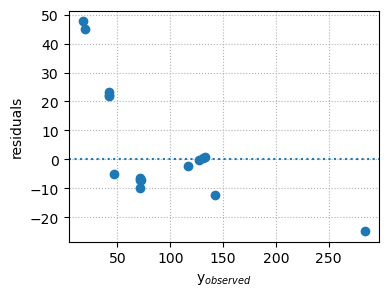

In [8]:
y_calc = lambda x, *k: k[0]*x[0]*x[1]/(1+k[1]*x[2]+k[2]*x[0])

bnds = [(0.0, 200), (0.0, 10), (0.0, 10)]

root = fsolve(lambda k: y_calc(x_data[:, :3], *k), [1, 1, 1]) # for estimating initial guess

sol = minimize(lambda k, x, y: np.linalg.norm(y - y_calc(x, *k)),
               root,
               args=(x_data, y_observed), 
               method='SLSQP',
               bounds=bnds)

fig, ax = plt.subplots(figsize = (4,3))

ax.plot(y_observed, y_calc(x_data, *sol.x) - y_observed, 'o')
ax.set_xlabel('y$_{observed}$')
ax.set_ylabel('residuals')
ax.axhline(y = 0, linestyle = ":")
ax.grid(linestyle = ':')

sol.x

# 5th method with residuals plots

k  =  119.36146757456665
Kb  =  0.026470671150680178
Kt  =  0.841818968854278


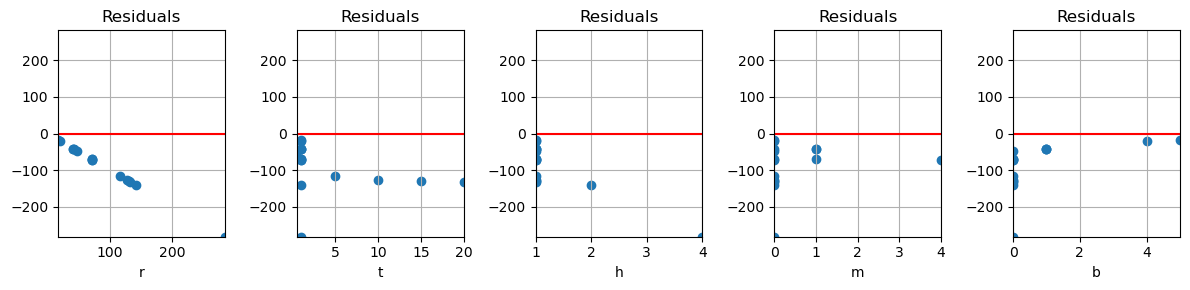

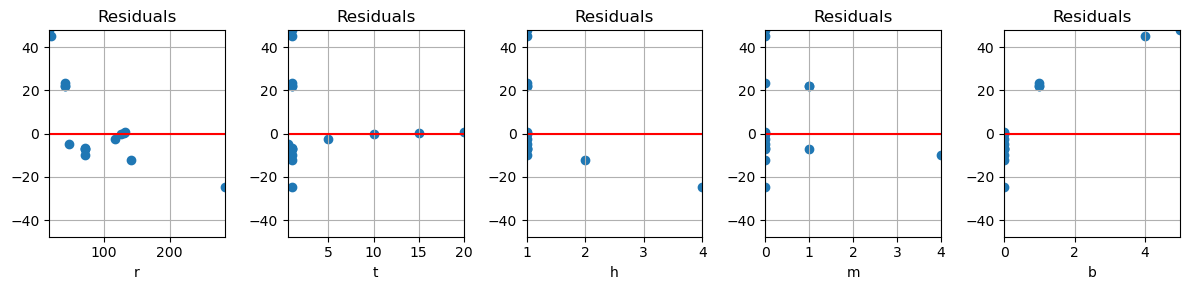

In [9]:
def fun(x, *params):
    
    k, Kb, Kt = params
    
    num = k*x[0]*x[1]
    denom = 1+Kb*x[2]+Kt*x[0]
    y = num/denom 
    
    return y


def residuals(params, x, y):
    
    return fun(x, *params) - y


def min_fun(params, x, y):
    
    return np.linalg.norm(y - fun(x, *params))
  
parameter_names = ['k', 'Kb', 'Kt']
parameter_guess = [1, 1, 1]
parameter_bounds = [(0.0, 200), (0.0, 10), (0.0, 10)]

###################################################################
def plot_residuals(r, df, ax=None):
    rmax = np.max(np.abs(r))
    if ax is None:
        fig, ax = plt.subplots(1, len(df.columns), figsize=(12,3))
    else:
        rmax = max(ax[0].get_ylim()[1], rmax)
    n = 0
    for c in df.columns:
        ax[n].scatter(df[c], r)
        ax[n].set_ylim(-rmax, rmax)
        ax[n].set_xlim(min(df[c]), max(df[c]))
        ax[n].plot(ax[n].get_xlim(), [0,0], 'r')
        ax[n].set_xlabel(c)
        ax[n].set_title('Residuals') 
        ax[n].grid(True)
        n += 1
    plt.tight_layout()
###################################################################

sol = minimize(min_fun, 
               parameter_guess, 
               args=(x_data, y_observed), 
               method='SLSQP',
               bounds=parameter_bounds)

for name, value in zip(parameter_names, sol.x):
    print(name, " = ", value)

r = residuals(parameter_guess, x_data, y_observed)    
ax = plot_residuals(r, df)

r_best = residuals(sol.x, x_data, y_observed)
plot_residuals(r_best, df, ax=ax)